In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [11]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data <- read_csv(url, col_names = names)
data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [15]:
# DESCRIPTION OF VARIABLES
# age, in years
# sex (1 = male; 0 = female)
# cp: chest pain type
#     -- Value 1: typical angina
#     -- Value 2: atypical angina
#     -- Value 3: non-anginal pain
#     -- Value 4: asymptomatic
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholestoral in mg/dl
# fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
# restecg: resting electrocardiographic results
#     -- Value 0: normal
#     -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
#                 elevation or depression of > 0.05 mV)
#     -- Value 2: showing probable or definite left ventricular hypertrophy
#                 by Estes' criteria
# thalach: maximum heart rate achieved
# exang: exercise induced angina (1 = yes; 0 = no)
# oldpeak = ST depression induced by exercise relative to rest
# slope: the slope of the peak exercise ST segment
#     -- Value 1: upsloping
#     -- Value 2: flat
#     -- Value 3: downsloping
# ca: number of major vessels (0-3) colored by flourosopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
# num: diagnosis of heart disease (angiographic disease status)
#     -- Value 0: < 50% diameter narrowing
#     -- Value 1: > 50% diameter narrowing

In [ ]:
# age, trestbps, chol predicts num?
# possibly also thalach

In [16]:
data <- data %>%
    mutate(num = as_factor(num))
data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [19]:
data_select <- select(data, c("age", "trestbps", "chol", "num"))
data_select

age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


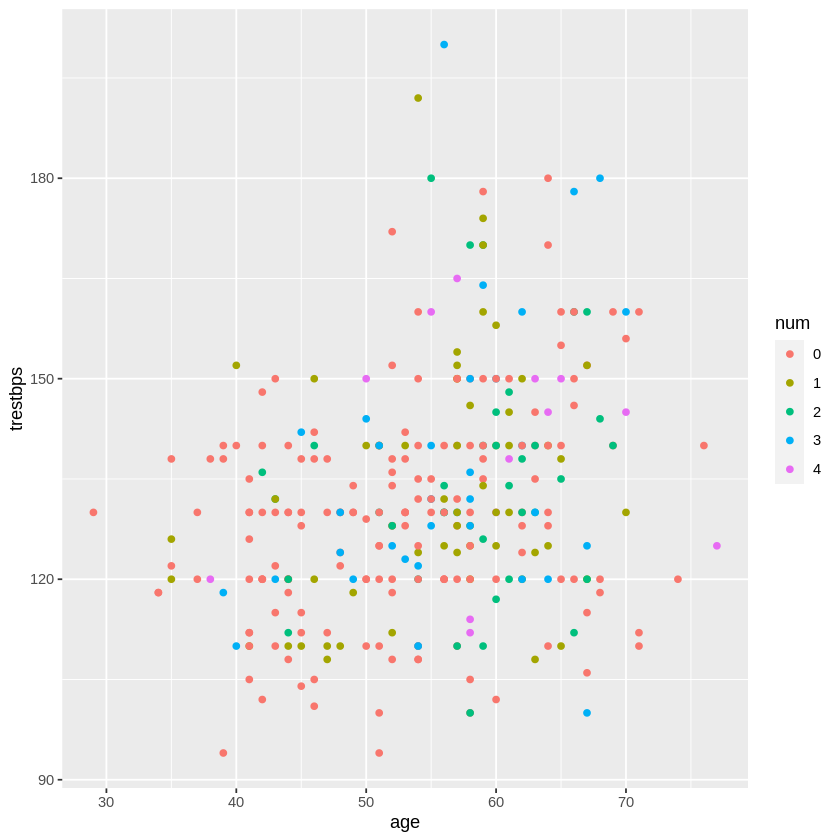

In [23]:
plot <- ggplot(data_select, aes(x = age, y = trestbps, color = num)) + 
    geom_point()
plot

Warning message in data(SAheart):
“data set ‘SAheart’ not found”
